# Tutorial 7d - Three Mirror Anastigmat (TMA)

This tutorial aims at demonstrating Optiland's capabilities in reflective systems design using freeform mirrors.

### Setup the telescope

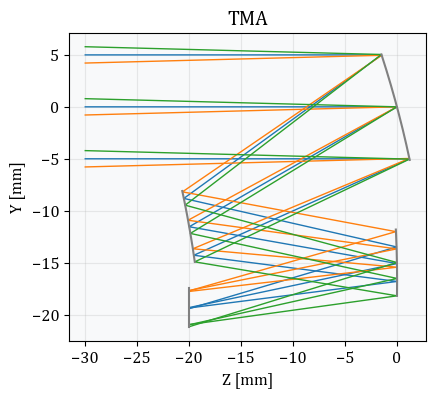

╒════╤══════════════════════╤══════════╤═════════════╤════════════╤═════════╤═════════════════╕
│    │ Type                 │   Radius │   Thickness │ Material   │   Conic │   Semi-aperture │
╞════╪══════════════════════╪══════════╪═════════════╪════════════╪═════════╪═════════════════╡
│  0 │ Planar               │      inf │         inf │ Air        │       0 │         5       │
│  1 │ Stop - Polynomial XY │     -100 │         -20 │ Mirror     │       0 │         5       │
│  2 │ Polynomial XY        │     -100 │          20 │ Mirror     │       0 │         3.52372 │
│  3 │ Polynomial XY        │     -100 │         -20 │ Mirror     │       0 │        12.6569  │
│  4 │ Planar               │      inf │         nan │ Air        │       0 │         4.72736 │
╘════╧══════════════════════╧══════════╧═════════════╧════════════╧═════════╧═════════════════╛


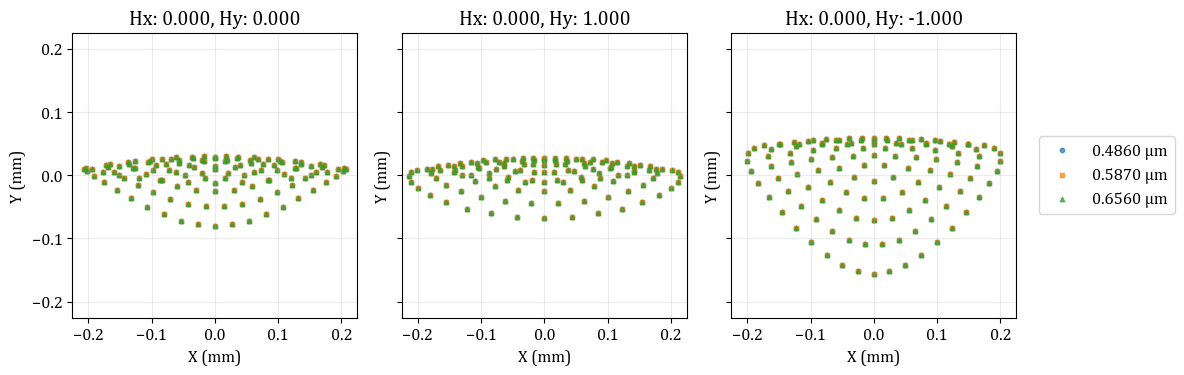

In [1]:
import numpy as np
from optiland import optic, analysis, optimization

focal_length = 100  # [mm]

lens = optic.Optic(name="TMA")
lens.set_aperture(aperture_type='EPD', value=10)
lens.set_field_type(field_type='angle')
lens.add_field(y=0)
lens.add_field(y=+1.5)
lens.add_field(y=-1.5)
lens.add_wavelength(value=0.486)
lens.add_wavelength(value=0.587, is_primary=True)
lens.add_wavelength(value=0.656)

lens.add_surface(index=0, radius=np.inf, thickness=np.inf)
lens.add_surface(index=1, radius=-100, thickness=-20, conic=0, material='mirror', rx=np.radians(-15.0), is_stop=True, surface_type='polynomial', coefficients=[])
lens.add_surface(index=2, radius=-100, thickness=+20, conic=0, material='mirror', rx=np.radians(-10.0), dy=-11.5, surface_type='polynomial', coefficients=[])
lens.add_surface(index=3, radius=-100, thickness=-20, conic=0, material='mirror', rx=np.radians(-1.0), dy=-15, surface_type='polynomial', coefficients=[])
lens.add_surface(index=4, dy=-19.3)

lens.update_paraxial()
lens.draw(title=lens.name)
lens.info()
spot = analysis.SpotDiagram(lens)
spot.view()

## Optimization

The optimization variables are the radii, thicknesses, decenters & tilts, and the freeform coefficients.

We define contraints on the mirrors' decenters to prevent vignetting.

### Variables

In [2]:
problem = optimization.OptimizationProblem()

# radii
problem.add_variable(lens, 'radius', surface_number=1, min_val=-1000, max_val=1000)
problem.add_variable(lens, 'radius', surface_number=2, min_val=-1000, max_val=1000)
problem.add_variable(lens, 'radius', surface_number=3, min_val=-1000, max_val=1000)

# thicknesses
problem.add_variable(lens, 'thickness', surface_number=1, min_val=-35, max_val=-15)
problem.add_variable(lens, 'thickness', surface_number=2, min_val=+15, max_val=+35)
problem.add_variable(lens, 'thickness', surface_number=3, min_val=-35, max_val=-15)

# decenters
problem.add_variable(lens, 'decenter', axis='y', surface_number=2, min_val=-15, max_val=-10)
problem.add_variable(lens, 'decenter', axis='y', surface_number=3, min_val=-20, max_val=-11)
problem.add_variable(lens, 'decenter', axis='y', surface_number=4, min_val=-25, max_val=-19)

# tilts
problem.add_variable(lens, 'tilt', axis='x', surface_number=1, min_val=np.radians(-20.0), max_val=np.radians(-12.0))
problem.add_variable(lens, 'tilt', axis='x', surface_number=2, min_val=np.radians(-15.0), max_val=np.radians(-08.0))
problem.add_variable(lens, 'tilt', axis='x', surface_number=3, min_val=np.radians(-05.0), max_val=np.radians(+05.0))

# conic constants
problem.add_variable(lens, 'conic', surface_number=1, min_val=-10, max_val=10)
problem.add_variable(lens, 'conic', surface_number=2, min_val=-10, max_val=10)
problem.add_variable(lens, 'conic', surface_number=3, min_val=-10, max_val=10)

# Freeform coefficients
for s in range(1,4):
    for i in range(4):
        for j in range(4):
            problem.add_variable(lens, 'polynomial_coeff', surface_number=s, coeff_index=(i,j), min_val=-1, max_val=1)

### Operands

In [3]:
# Center M2 on its chief ray
input_data = {'optic': lens, 'surface_number': 2, 'Hx': 0, 'Hy': 0, 'Px': 0, 'Py': 0, 'wavelength': 0.587}
problem.add_operand(operand_type='real_y_intercept_lcs',
                    target=0,
                    weight=1,
                    input_data=input_data)

# Center M3 on its chief ray
input_data = {'optic': lens, 'surface_number': 3, 'Hx': 0, 'Hy': 0, 'Px': 0, 'Py': 0, 'wavelength': 0.587}
problem.add_operand(operand_type='real_y_intercept_lcs',
                    target=0,
                    weight=1,
                    input_data=input_data)

# Image surface - Real ray heights operands, in the lcs of the image surface
# Center the image surface on its chief ray
input_data = {'optic': lens, 'surface_number': 4, 'Hx': 0, 'Hy': 0, 'Px': 0, 'Py': 0, 'wavelength': 0.587}
problem.add_operand(operand_type='real_y_intercept_lcs',
                    target=focal_length*np.tan(np.deg2rad(lens.fields.y_fields[0])),
                    weight=1,
                    input_data=input_data)
input_data = {'optic': lens, 'surface_number': 4, 'Hx': 0, 'Hy': 1, 'Px': 0, 'Py': 0, 'wavelength': 0.587}
problem.add_operand(operand_type='real_y_intercept_lcs',
                    target=focal_length*np.tan(np.deg2rad(lens.fields.y_fields[1])),
                    weight=1,
                    input_data=input_data)
input_data = {'optic': lens, 'surface_number': 4, 'Hx': 0, 'Hy': -1, 'Px': 0, 'Py': 0, 'wavelength': 0.587}
problem.add_operand(operand_type='real_y_intercept_lcs',
                    target=focal_length*np.tan(np.deg2rad(lens.fields.y_fields[2])),
                    weight=1,
                    input_data=input_data)

# RMS spot size - let's minimize the spot size for each field at the primary wavelength.
# We choose a 'uniform' distribution, so the number of rays actually means the rays on one axis. 
# Therefore we trace ≈16^2 rays here.
for field in lens.fields.get_field_coords():
    input_data = {'optic': lens, 'surface_number': 4, 'Hx': field[0], 'Hy': field[1], 'num_rays': 16,
                  'wavelength': 0.587, 'distribution': 'uniform'}
    problem.add_operand(operand_type='rms_spot_size', target=0, weight=10, input_data=input_data)

# Focal length - Redundant with real ray heights operands
# problem.add_operand(operand_type='f2', target=focal_length, weight=1, input_data={'optic': lens})

problem.info()

╒════╤════════════════════════╤═══════════════════╕
│    │   Merit Function Value │   Improvement (%) │
╞════╪════════════════════════╪═══════════════════╡
│  0 │                5.31874 │                 0 │
╘════╧════════════════════════╧═══════════════════╛
╒════╤══════════════════════╤══════════╤══════════╤════════════╤════════════╤════════════════════╕
│    │ Operand Type         │   Target │   Weight │      Value │      Delta │   Contribution (%) │
╞════╪══════════════════════╪══════════╪══════════╪════════════╪════════════╪════════════════════╡
│  0 │ real y intercept lcs │  0       │        1 │ -0.0426673 │ -0.0426673 │         0.034228   │
│  1 │ real y intercept lcs │  0       │        1 │ -0.0860058 │ -0.0860058 │         0.139074   │
│  2 │ real y intercept lcs │  0       │        1 │ -0.0196008 │ -0.0196008 │         0.00722339 │
│  3 │ real y intercept lcs │  2.61859 │        1 │  1.62219   │ -0.996405  │        18.6665     │
│  4 │ real y intercept lcs │ -2.61859 │       

### Optimization

╒════╤══════════════════════╤═══════════╤═════════════╤════════════╤══════════════╤═════════════════╕
│    │ Type                 │    Radius │   Thickness │ Material   │        Conic │   Semi-aperture │
╞════╪══════════════════════╪═══════════╪═════════════╪════════════╪══════════════╪═════════════════╡
│  0 │ Planar               │  inf      │    inf      │ Air        │  0           │         5       │
│  1 │ Stop - Polynomial XY │  -99.9773 │    -20.0003 │ Mirror     │  2.35645e-06 │         5       │
│  2 │ Polynomial XY        │ -100.019  │     20.0003 │ Mirror     │ -2.21455e-07 │         3.52324 │
│  3 │ Polynomial XY        │  -99.9774 │    -20.0003 │ Mirror     │  5.32063e-08 │        12.654   │
│  4 │ Planar               │  inf      │    nan      │ Air        │  0           │         4.71901 │
╘════╧══════════════════════╧═══════════╧═════════════╧════════════╧══════════════╧═════════════════╛


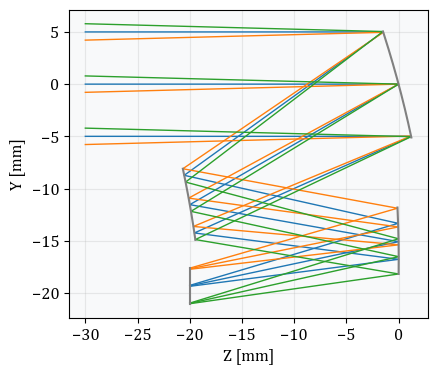

╒════╤════════════════════════╤═══════════════════╕
│    │   Merit Function Value │   Improvement (%) │
╞════╪════════════════════════╪═══════════════════╡
│  0 │                2.08552 │           60.7891 │
╘════╧════════════════════════╧═══════════════════╛
╒════╤══════════════════════╤══════════╤══════════╤════════════╤════════════╤════════════════════╕
│    │ Operand Type         │   Target │   Weight │      Value │      Delta │   Contribution (%) │
╞════╪══════════════════════╪══════════╪══════════╪════════════╪════════════╪════════════════════╡
│  0 │ real y intercept lcs │  0       │        1 │ -0.043906  │ -0.043906  │          0.0924341 │
│  1 │ real y intercept lcs │  0       │        1 │ -0.0897    │ -0.0897    │          0.385807  │
│  2 │ real y intercept lcs │  0       │        1 │ -0.0254183 │ -0.0254183 │          0.0309799 │
│  3 │ real y intercept lcs │  2.61859 │        1 │  1.61103   │ -1.00756   │         48.6772    │
│  4 │ real y intercept lcs │ -2.61859 │       

In [4]:
# Local optimizer
optimizer = optimization.OptimizerGeneric(problem)
res = optimizer.optimize(disp=True)

# Global optimizer
# optimizer = optimization.DifferentialEvolution(problem)
# res = optimizer.optimize(maxiter=100, disp=True, workers=-1)

lens.info()
lens.draw()
problem.info()

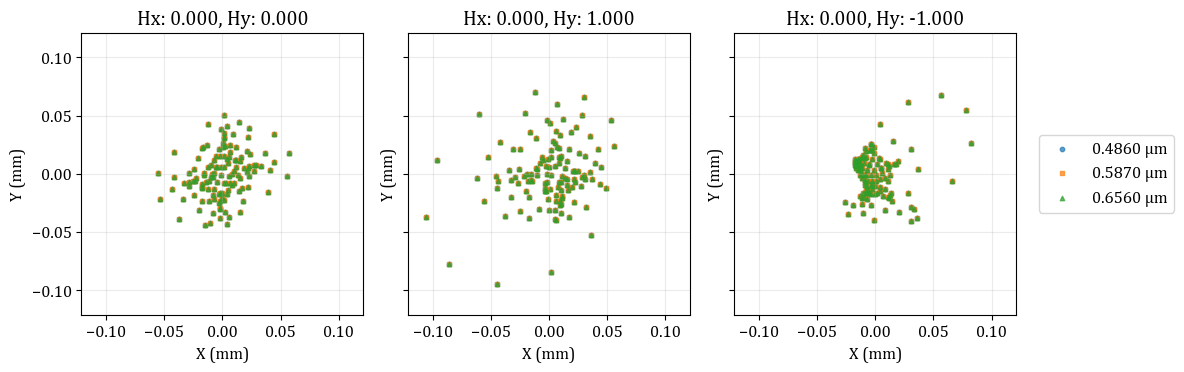

In [5]:
spot = analysis.SpotDiagram(lens)
spot.view()